# <center> [👀🚗 Визуализация. Ошибки модели](https://stepik.org/lesson/826359/) </center>

### Оглавление ноутбука 

<p><font size="3" face="Arial" font-size="large"><ul type="square">
    
<li><a href="#c1">📊 Важность фичей </a></li>
<li><a href="#c2">📂 SHAP values :</a></li>
<li><a href="#look1"> 📦 classification report </a>
<li><a href="#look1"> 👁‍ Матрица смежности </a>
<li><a href="#check1"> 📈 Регрессия и остатки</a>  
<li><a href="#check1"> 🤷‍ График (True - Pred) vs (True + Pred) </a>

<li><a href="#6">🧸 Выводы и заключения</a>

</li></ul></font></p>

<center> <img src='../images/viz_mistakes.JPG' width="1050" height="1050" />

<div class="alert alert-info">
    
* Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например: 
    * Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки
    * Сделать выводы, как можно улучшить точность в последующих экспериментах.
    * Визуализировать ошибки модели
    * Отсеять лишние признаки
    * Найти идеи для новых признаков.
    * Все зависит от типа ваших данных

In [1]:
!pip install catboost scikit-learn shap seaborn matplotlib -q

DEPRECATION: pytorch-lightning 1.6.5 has a non-standard dependency specifier torch>=1.8.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,random_feature_1,random_feature_2,random_feature_3
1351,Y17319354d,Smart ForFour,economy,petrol,3.32,2017,123031,2018,64.11,engine_ignition,4.086149,9.134994e+06,0.10,189.313525,9.269340,174,172,0.304435,-0.632751,11
61,E-1356165C,Kia Sportage,standart,petrol,3.72,2015,75739,2016,34.24,break_bug,5.402299,8.515353e+06,0.85,106.637977,-3.330332,174,174,0.661895,-1.029031,40
1477,Z-2109687y,Hyundai Solaris,economy,petrol,5.76,2013,45373,2017,26.15,wheel_shake,4.634655,1.127376e+07,0.10,119.000000,11.754774,174,166,0.363709,-0.020872,46


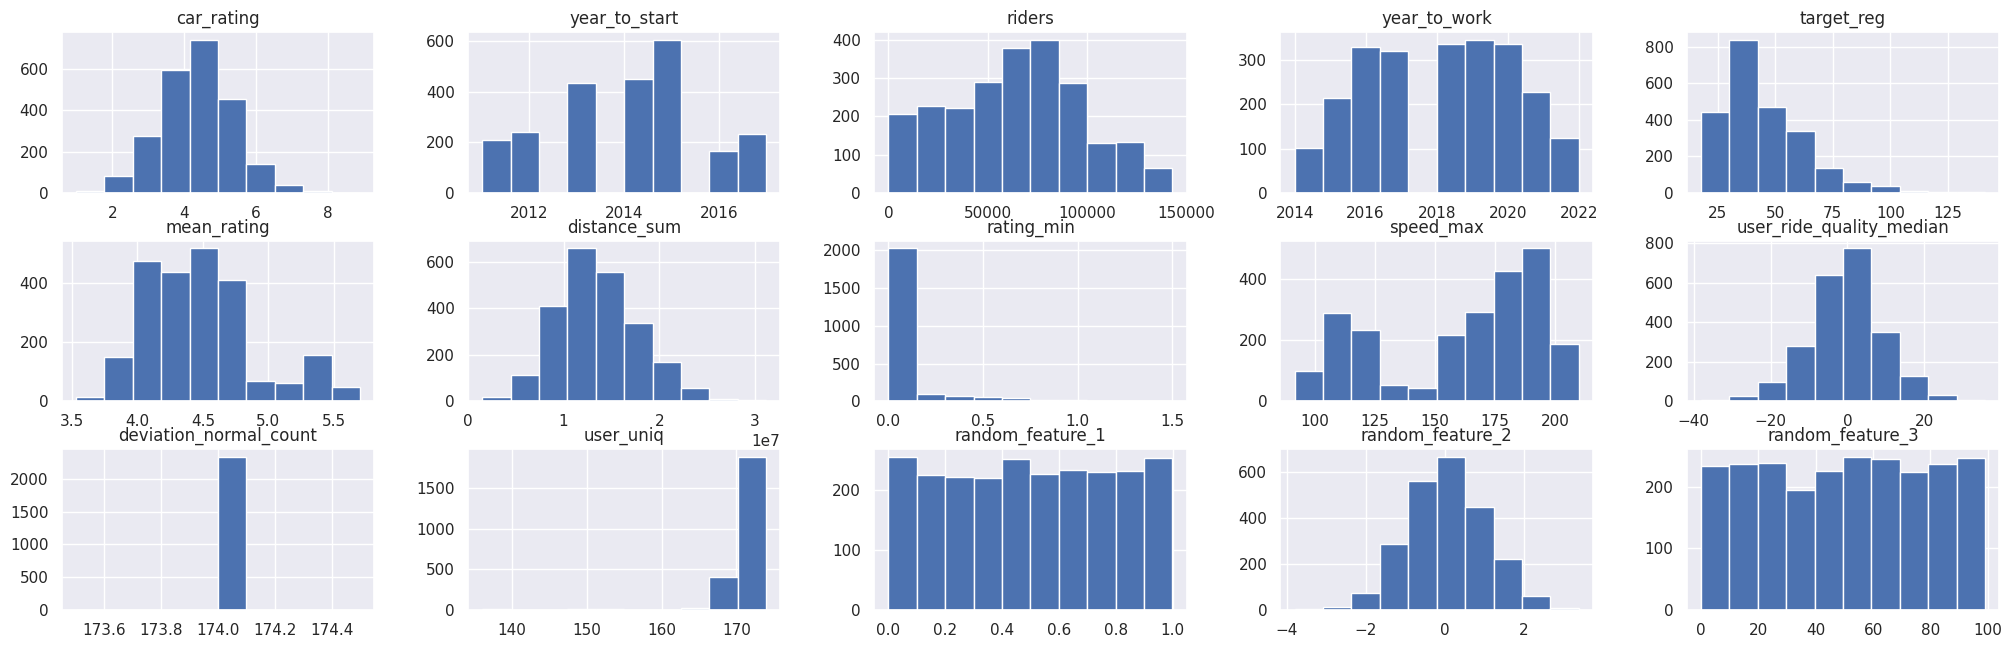

In [3]:
path = "../data/quickstart_train.csv"
train = pd.read_csv(path)

# Добавим пару рандомных признаков для последующего анализа
train['random_feature_1'] = np.random.random(size = train.shape[0])
train['random_feature_2'] = np.random.normal(size = train.shape[0])
train['random_feature_3'] = np.random.randint(100, size = train.shape[0])

train.hist(figsize=(25, 7.5), layout=(-1, 5))
train.sample(3)

In [4]:
from sklearn.model_selection import train_test_split

drop_cols = ['user_id', 'car_id', 'ride_id', 'ride_date']
cat_cols = ['car_type', 'fuel_type', 'model']

y = train['target_class']
X = train.drop(drop_cols + ['target_reg', 'target_class'], axis=1, errors = 'ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# <center> 🤹‍♀️ Классификация

In [5]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                        colsample_bylevel =  0.1,
                        subsample = 0.95,
                        bootstrap_type='Bernoulli')

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=250,
        plot=False,
        early_stopping_rounds=100)

print(clf.get_best_score())

Learning rate set to 0.109335
0:	learn: 2.0415376	test: 2.0431216	best: 2.0431216 (0)	total: 51.1ms	remaining: 51s
250:	learn: 0.3438081	test: 0.5610850	best: 0.5609716 (247)	total: 1.14s	remaining: 3.41s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5442371535
bestIteration = 363

Shrink model to first 364 iterations.
{'learn': {'MultiClass': 0.23244135070997407}, 'validation': {'MultiClass': 0.5442371535384456}}


# <center> Визуализируем важность фичей для `Catboost`


In [6]:
# Посмотрим важность признаков
fi = clf.get_feature_importance(prettified=True)
fi[:20] # .style.background_gradient(cmap='viridis', subset=pd.IndexSlice[0:10, 'Importances'])

,Feature Id,Importances
0,speed_max,36.452910
1,mean_rating,29.601864
2,rating_min,12.073451
3,user_uniq,4.281560
4,car_type,2.565602
5,model,1.917238
6,car_rating,1.726318
7,distance_sum,1.631956
8,random_feature_3,1.591137
9,user_ride_quality_median,1.428575



Не стоит сильно доверять этому рейтингу важности, т.к. для сильно скоррелированных признаков импортанс делится пополам и они оба могут улететь вниз по важности.

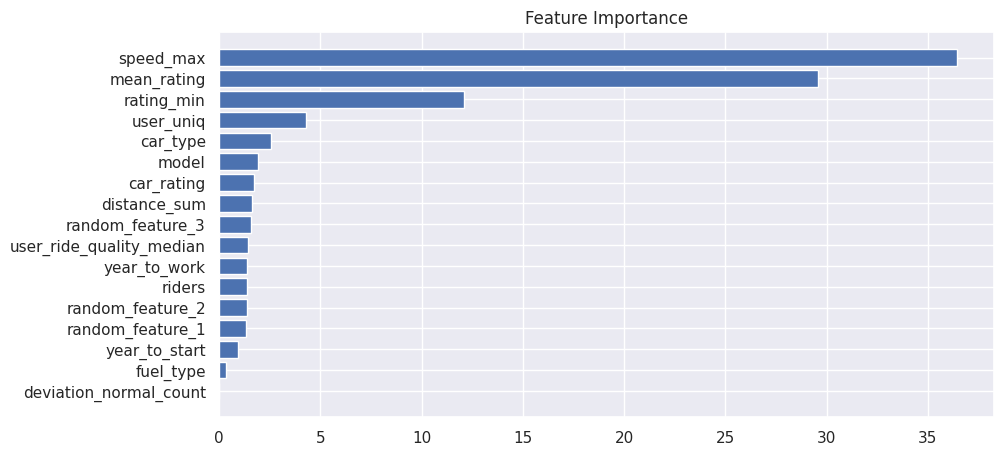

In [7]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance');

##  **График важности признаков при кросс-валидации с помощью `Seaborn`**

In [8]:
from sklearn.model_selection import KFold

n_splits = 5
targets = ['target_class']
clfs = []
scores = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_cols)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)

    clf = CatBoostClassifier(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                        colsample_bylevel =  0.1,
                        subsample = 0.95,
                        bootstrap_type='Bernoulli',)

    clfs.append(clf)

    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = False, use_best_model = True, plot = False)

    scores.append(np.mean([v for k, v in clf.best_score_['validation'].items()], dtype = 'float16'))
    
print('mean recall score --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))

mean recall score ---------> 0.5063 0.02632


## **Функция для отображения разброса важности признаков по фолдам.**

In [9]:
from src.utils import plot_importance

Всего признаков 17 Усреднее по 5-ти моделям: 
На график нанесено топ-14 признаков


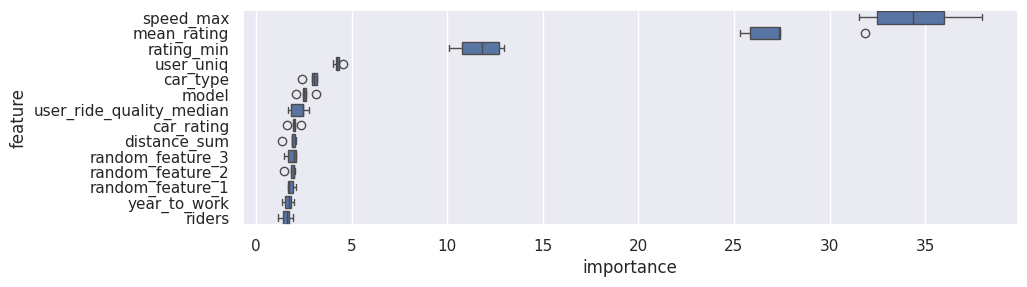

In [10]:
# Строим важность по всем фолдам сразу
df_feats_imp = plot_importance(X, clfs, height = 0.20, top_n = 14)

**Посмотрим на графики важности более точных методов**

## <center><b> 🔁 Permutation importance </b></center> 

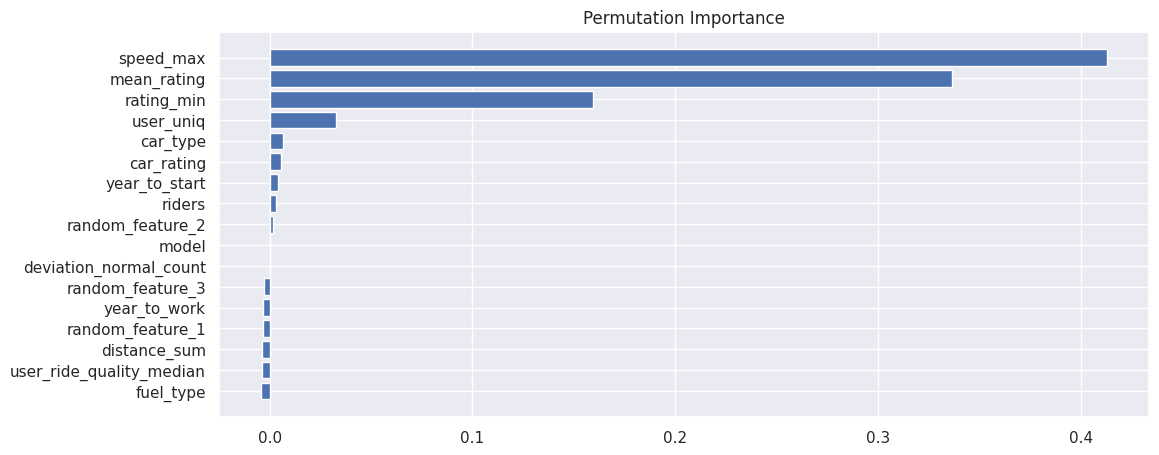

In [11]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 5))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance');

<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png">

<div class="alert alert-info">
    
В библиотеке SHAP для оценки важности признаков рассчитываются значения Шэпли (по имени американского математика и названа библиотека), она обладает богатым функционалом визуализации, который помогает легко и просто объяснить модель.

Для оценки важности фичи происходит оценка предсказаний модели с и без данной фичи.

In [12]:
# Библиотека shap бывает капризна в установке и может конфликтовать с другими пакетами
# Иногда помогает такой набор команд
#!pip uninstall opencv-python -y -q
#!pip install opencv-python shap -q

In [13]:
import shap
shap.initjs()

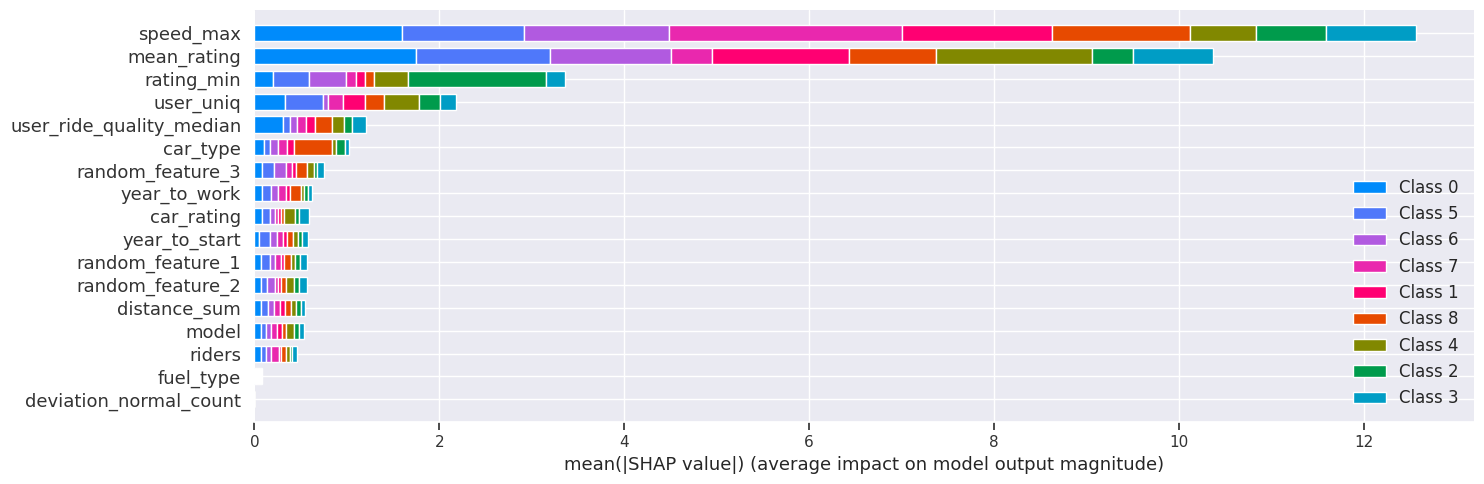

In [14]:
# Можем посмотреть влияние фичей на все классы
explainer = shap.TreeExplainer(clf)

val_dataset = Pool(data=X_test, label=y_test, cat_features=cat_cols)
shap_values = explainer.shap_values(val_dataset)
shap.summary_plot(shap_values, X_test, max_display = 25, plot_size = (15, 5))

Class 0


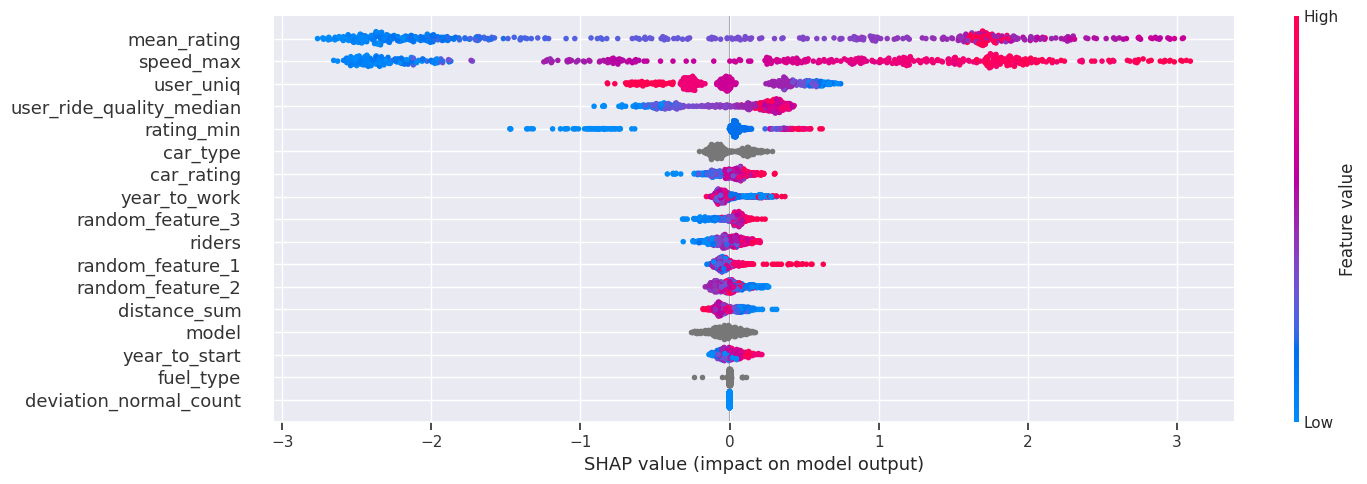

Class 1


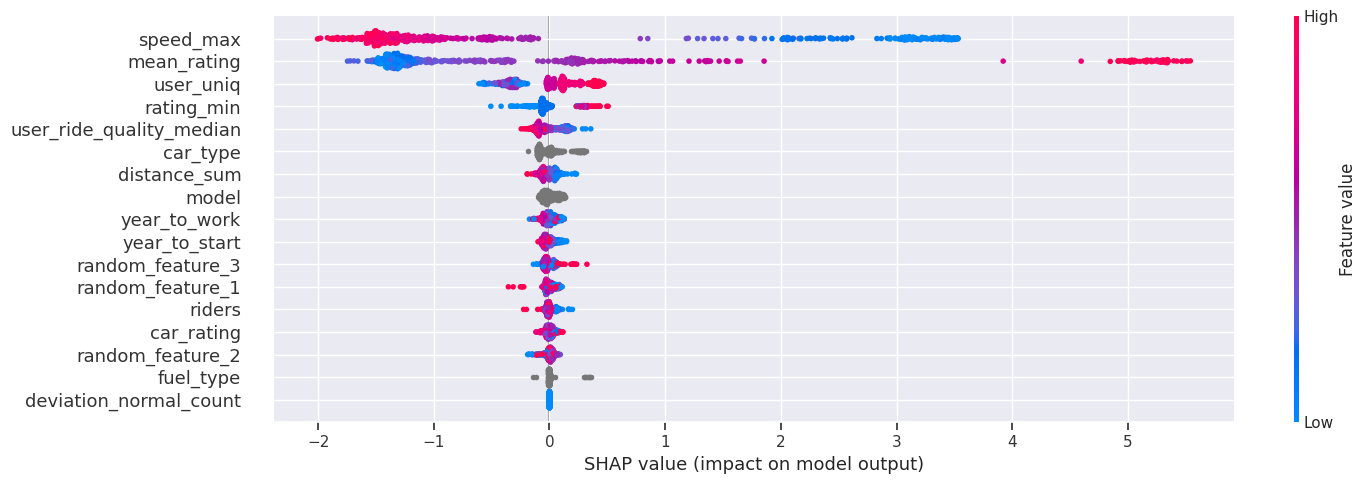

In [15]:
# Или на каждый класс по отдельности
for i in range(len(np.unique(y.values))):
    print(f'Class {i}')
    shap.summary_plot(shap_values[i], X_test, color_bar=True, plot_size = (15, 5))
    if i == 1:
        break
# shap.summary_plot(shap_values[1], X_test, color_bar=False)

# 📚 Как читать график?

<div class="alert alert-info">

* значения слева от центральной вертикальной линии — это **negative** класс (0), справа — **positive** (1)
* чем толще линия на графике, тем больше таких точек наблюдения
* чем краснее точки на графике, тем выше значения признака в ней

# <center>🤙 dependence_plot

<div class="alert alert-info">
    
Мы можем посмотреть влияние отдельной фичи на конкретный класс с помощью `dependence_plot` 

In [16]:
len(shap_values)

9

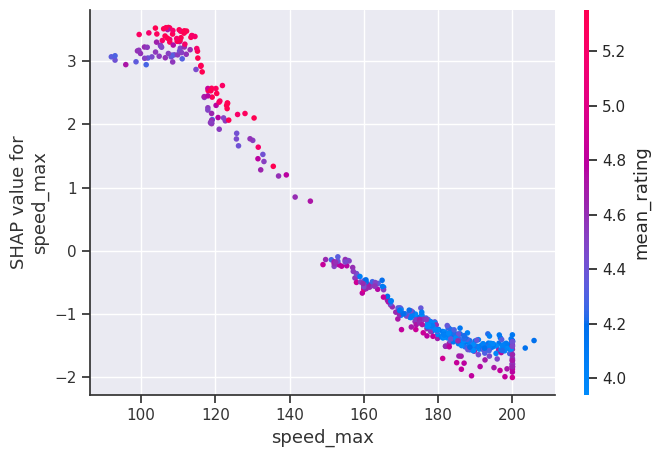

In [17]:
shap.dependence_plot("speed_max", shap_values[1], X_test)

<div class="alert alert-info">
    
    
Одна из самых крутых фишек баблиотеки SHAP, это возможность посмотреть как модель определяет к какому классу относится конкретная машина, и какие признаки на это влияют.
Посмотрим на примере первой машины из тестовой выборки.

In [18]:
X_test.iloc[0]

model                       Renault Sandero
car_type                           standart
fuel_type                            petrol
car_rating                              4.7
year_to_start                          2012
riders                                26428
year_to_work                           2017
mean_rating                        4.181149
distance_sum                13983174.664416
rating_min                              0.1
speed_max                        203.462289
user_ride_quality_median         -14.260456
deviation_normal_count                  174
user_uniq                               171
random_feature_1                    0.54281
random_feature_2                   -2.97197
random_feature_3                         10
Name: 4, dtype: object

In [19]:
# поломка "engine_fuel" это 4 класс
y_test.iloc[0]

'engine_fuel'

# <center> 💪 force_plot

<div class="alert alert-info">
      
* В этом нам помогут `force_plot` и просто "пушечный" вид графика `waterfall_plot`.
* Можно посмотреть на вклад каждого признака в то, что модель не отнесла поломку машины к классу 0 и отнесла к классу 4

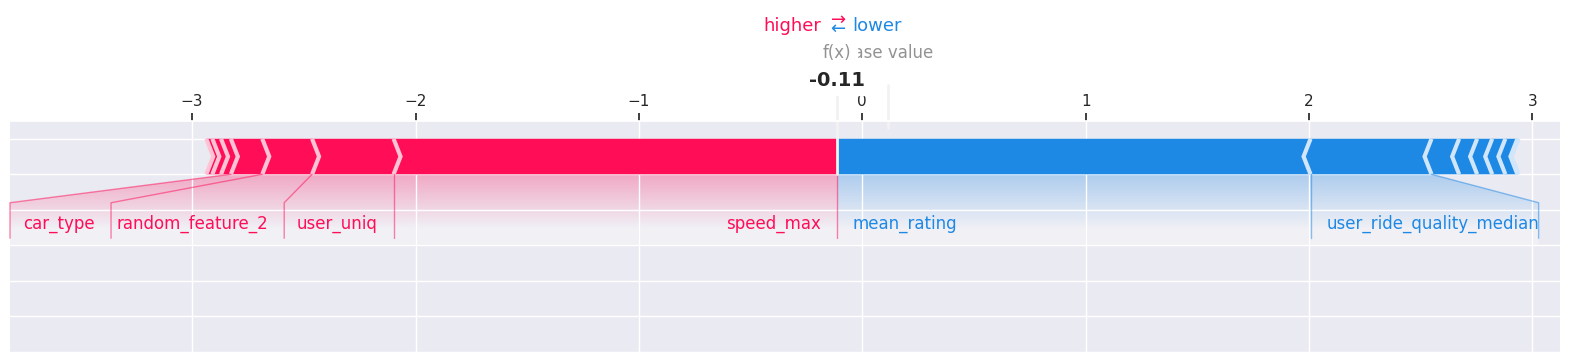

In [47]:
import matplotlib

shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=X_test.columns, matplotlib=matplotlib)

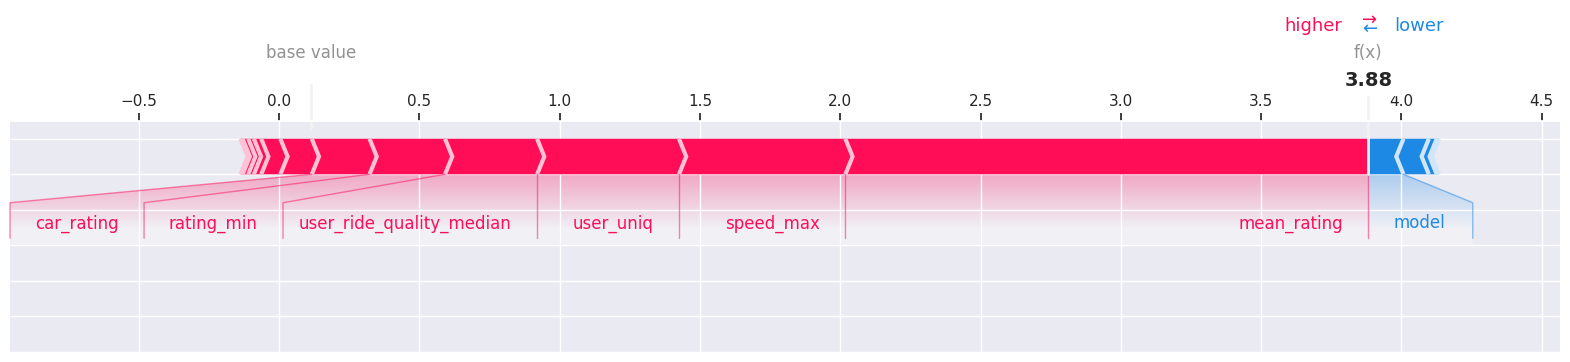

In [46]:
shap.force_plot(explainer.expected_value[0], shap_values[4][0], feature_names=X_test.columns, matplotlib=matplotlib)

# <center> 💧 Waterfall plot 

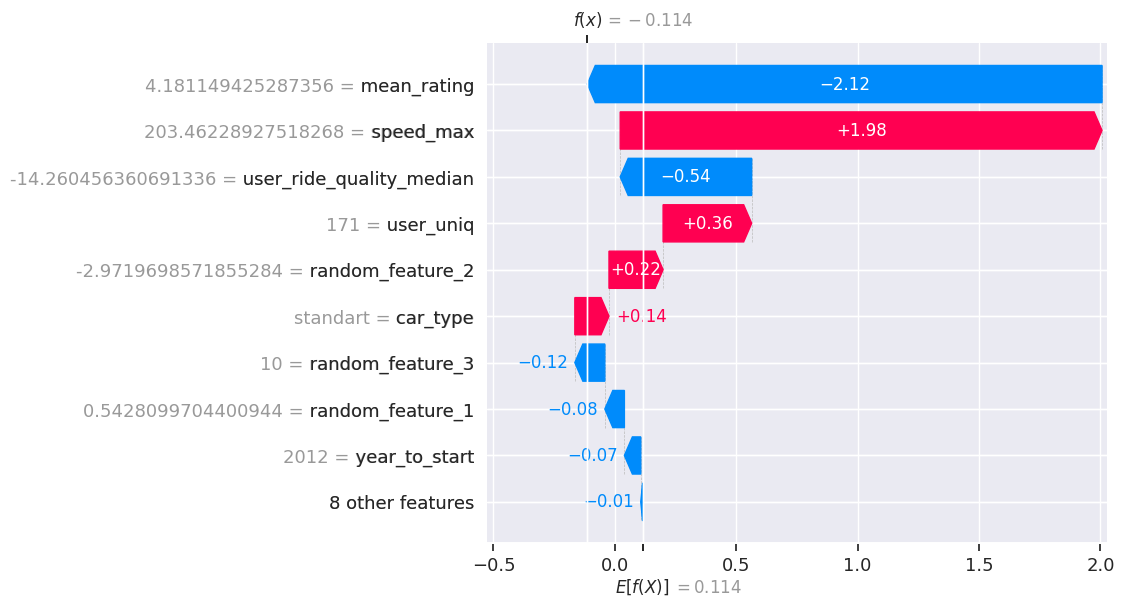

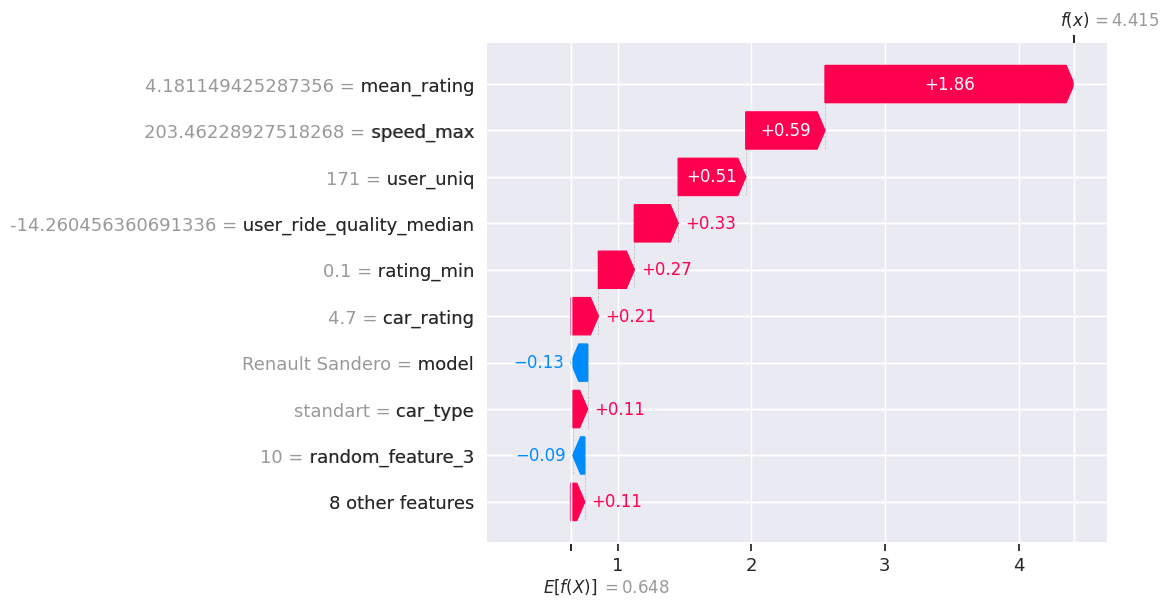

In [22]:
# waterfall_plot показывает численное влияние каждого признака
s_values = explainer(X_test)
shap.waterfall_plot(s_values[0][:, 0])
shap.waterfall_plot(s_values[0][:, 4])

В библиотеке [SHAP](https://shap.readthedocs.io/en/latest/index.html) есть ещё большое количество других графиков, а мы показали самые интересные и часто используемые.

# <center> 📦 `classification_report` - одна функция и сразу все метрики </center>

In [23]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_))

                 precision    recall  f1-score   support

    another_bug       0.92      0.81      0.86        59
      break_bug       1.00      1.00      1.00        56
    electro_bug       1.00      1.00      1.00        56
   engine_check       0.68      0.87      0.76        45
    engine_fuel       0.68      0.68      0.68        50
engine_ignition       0.55      0.46      0.50        61
engine_overheat       0.53      0.63      0.57        62
     gear_stick       0.98      0.92      0.95        48
    wheel_shake       0.85      0.73      0.79        30

       accuracy                           0.78       467
      macro avg       0.80      0.79      0.79       467
   weighted avg       0.79      0.78      0.78       467



In [24]:
rep = pd.DataFrame(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=clf.classes_,
                            output_dict=True)).T

rep['support'] = rep.support.apply(int)
rep.style.background_gradient(cmap='viridis', subset=pd.IndexSlice['another_bug':'wheel_shake', :'f1-score'])

,precision,recall,f1-score,support
another_bug,0.923077,0.813559,0.864865,59
break_bug,1.000000,1.000000,1.000000,56
electro_bug,1.000000,1.000000,1.000000,56
engine_check,0.684211,0.866667,0.764706,45
engine_fuel,0.680000,0.680000,0.680000,50
engine_ignition,0.549020,0.459016,0.500000,61
engine_overheat,0.527027,0.629032,0.573529,62
gear_stick,0.977778,0.916667,0.946237,48
wheel_shake,0.846154,0.733333,0.785714,30
accuracy,0.783726,0.783726,0.783726,0


# <center> 👁‍🗨 `confusion_matrix` - Матрица смежности ❎ </center>

Посмотрим в каких классах модель больше всего ошибается с помощью матрицы смежности

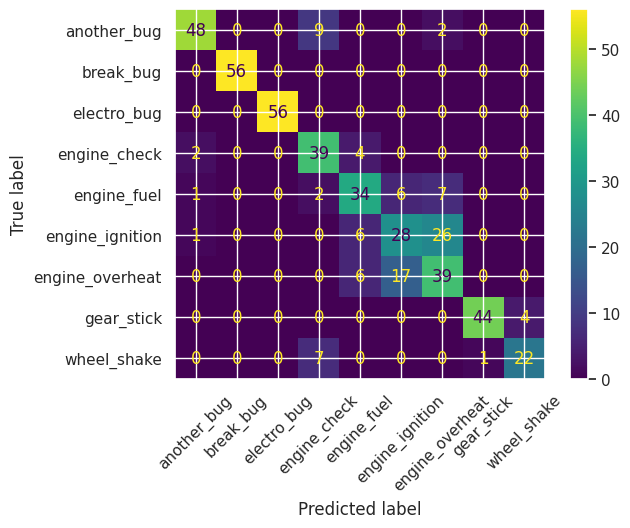

In [25]:
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, xticks_rotation = 45)
# Есть модель не под рукой
# ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation = 45)
# plt.show()

<Axes: >

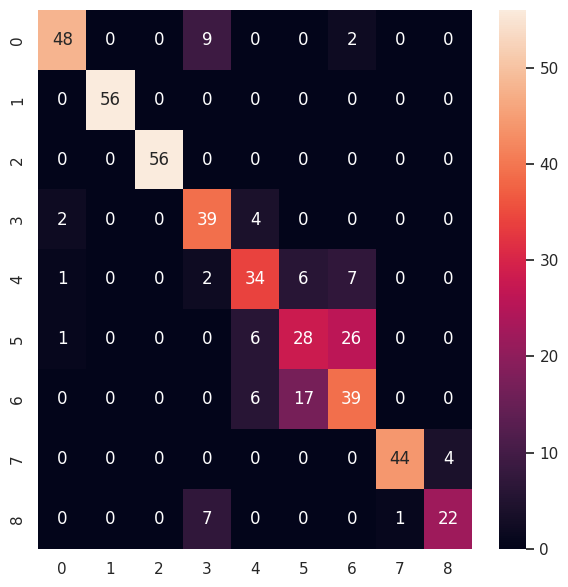

In [26]:
plt.rcParams['figure.figsize']=(7, 7)
cf = confusion_matrix(y_test, y_pred)
sns.heatmap(cf, annot=True)

In [27]:
from src.utils import plot_confusion, plot_importance

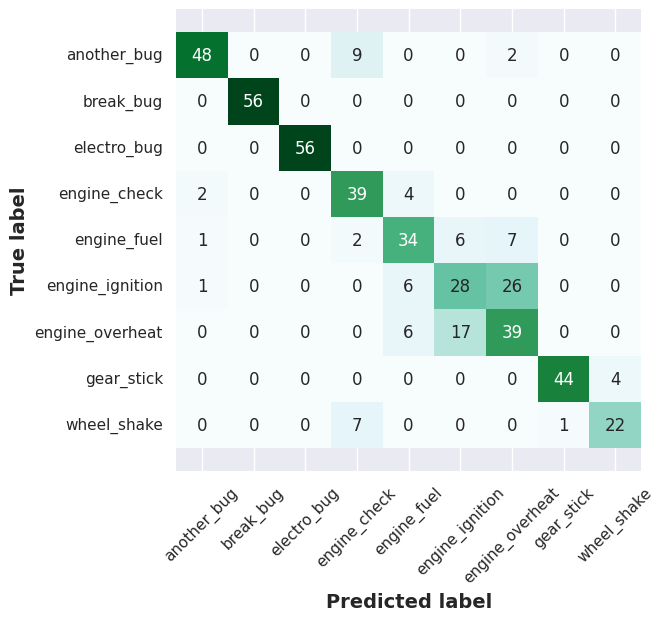

In [28]:
# Тот же спсособ выше, только чуть причесанный
plot_confusion(Y_test = y_test, Y_test_pred = y_pred, labels = clf.classes_ )

# 📚 Как читать график?

<div class="alert alert-info">

* Значения диагонали сверху вниз слева направо – это число верно предсказанных значений.
* Чем темнее квадрат, тем больше верных ответов.
* Можно сделать вывод, что модель больше всего путается между классами: `1 - 2`, `1 - 5`, `1- 6`, `2 - 3`, `5 - 6`.
* В целом, видно, что 1 и 5 классы хуже отделяются.

In [29]:
# !sudo apt update -y && sudo apt install graphviz -y -q

## Отрисуем дерево модели

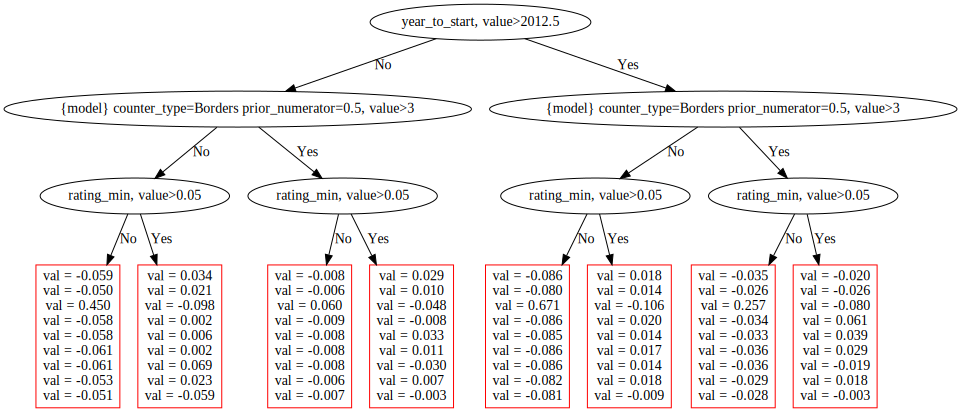

In [30]:
# Как минимум помогает понять, что такое дерево решений
clf.plot_tree(
    tree_idx=4,
    pool=val_dataset
)

# <center> 💹 `Partial plots` - влияние признаков на прогноз</center>
 Посмотрим как топовые фичи влияют на прогноз модели

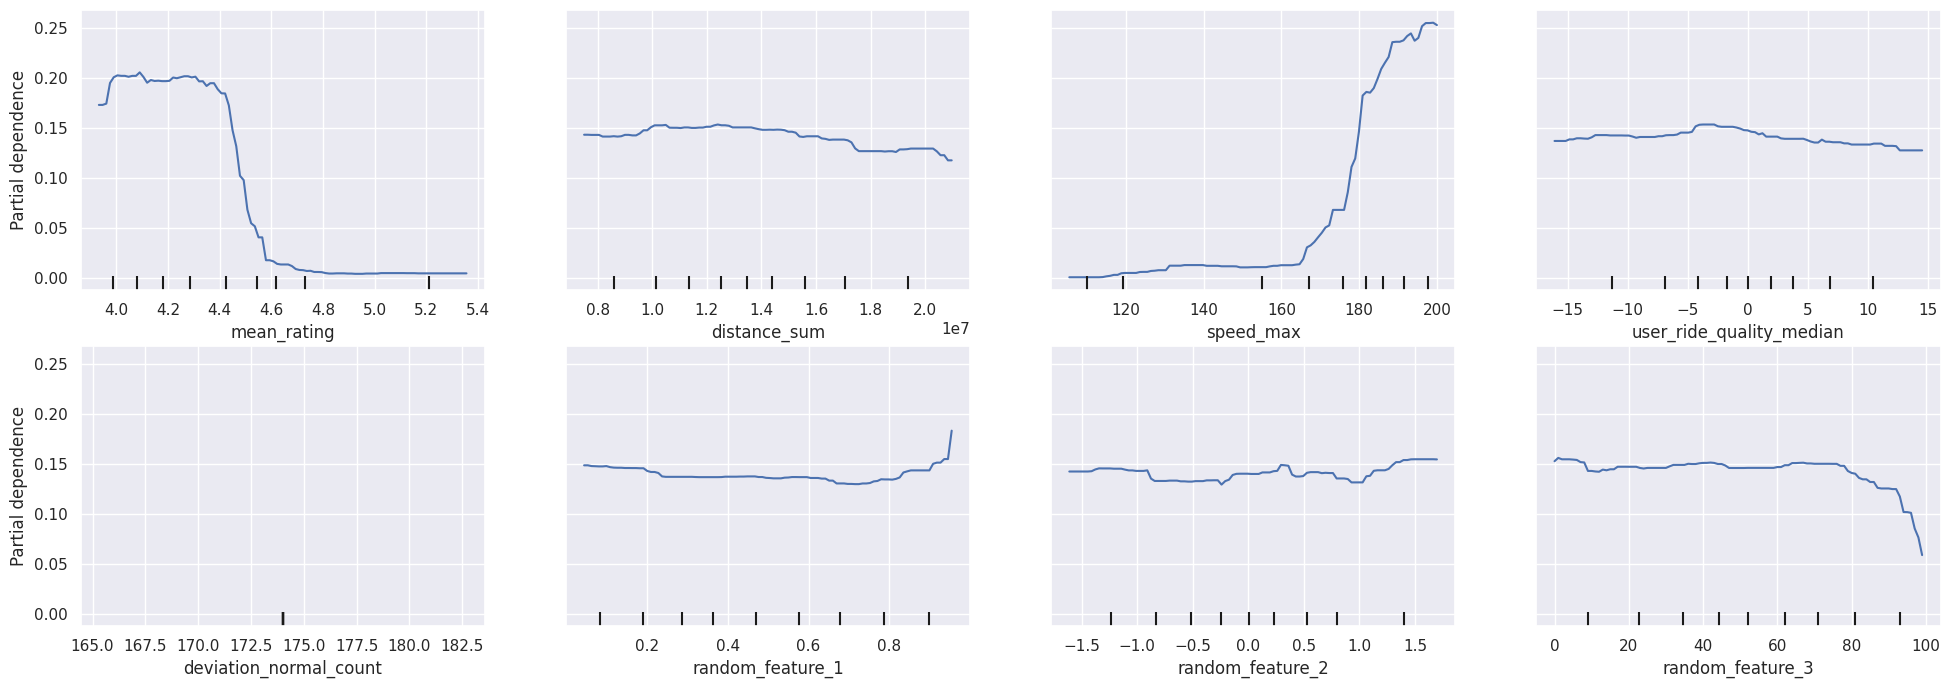

In [31]:
from sklearn.inspection import PartialDependenceDisplay

plt.rcParams['figure.figsize']=(24, 8)
features = X.drop(cat_cols, axis=1).columns

features = ['mean_rating', 'distance_sum', 'speed_max', 'user_ride_quality_median',
            'deviation_normal_count', 'random_feature_1', 'random_feature_2', 'random_feature_3']

PartialDependenceDisplay.from_estimator(clf, X_test,
                                        features = features,
                                        target='engine_overheat',
                                        n_cols=4,
                                        n_jobs=-1,
                                        random_state=42,)

# <center> 📈 Регрессия 

In [32]:
y = train['target_reg']
X = train.drop(drop_cols + ['target_reg','target_class'], axis=1, errors = 'ignore')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
regr = CatBoostRegressor(random_seed=9,
                        thread_count=-1,
                        use_best_model=True,
                        cat_features=cat_cols,
                         )

regr.fit( X_train, y_train, 
        eval_set=(X_test, y_test),
        verbose=50, plot=False, early_stopping_rounds=200)

print(regr.get_best_score())

Learning rate set to 0.056174
0:	learn: 17.0988040	test: 17.8186403	best: 17.8186403 (0)	total: 2.92ms	remaining: 2.92s
50:	learn: 11.2936736	test: 12.4083321	best: 12.4083321 (50)	total: 107ms	remaining: 1.98s
100:	learn: 10.4624335	test: 12.1318717	best: 12.1215330 (96)	total: 207ms	remaining: 1.84s
150:	learn: 9.8570599	test: 12.1011512	best: 12.0996942 (149)	total: 307ms	remaining: 1.73s
200:	learn: 9.2134898	test: 12.1435798	best: 12.0956228 (163)	total: 411ms	remaining: 1.63s
250:	learn: 8.6975519	test: 12.1711082	best: 12.0956228 (163)	total: 517ms	remaining: 1.54s
300:	learn: 8.1455935	test: 12.2334653	best: 12.0956228 (163)	total: 622ms	remaining: 1.44s
350:	learn: 7.7457876	test: 12.2653673	best: 12.0956228 (163)	total: 727ms	remaining: 1.34s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 12.0956228
bestIteration = 163

Shrink model to first 164 iterations.
{'learn': {'RMSE': 7.643840530177327}, 'validation': {'RMSE': 12.09562280249592}}


# <center> 🍇🐇 Смотрим на остатки
Когда делаем предсказание для задачи классификации, то, помимо метрики, также визуально оцениваем качество по  матрице ошибок. </br>
А когда делаете регрессию, куда смотреть?

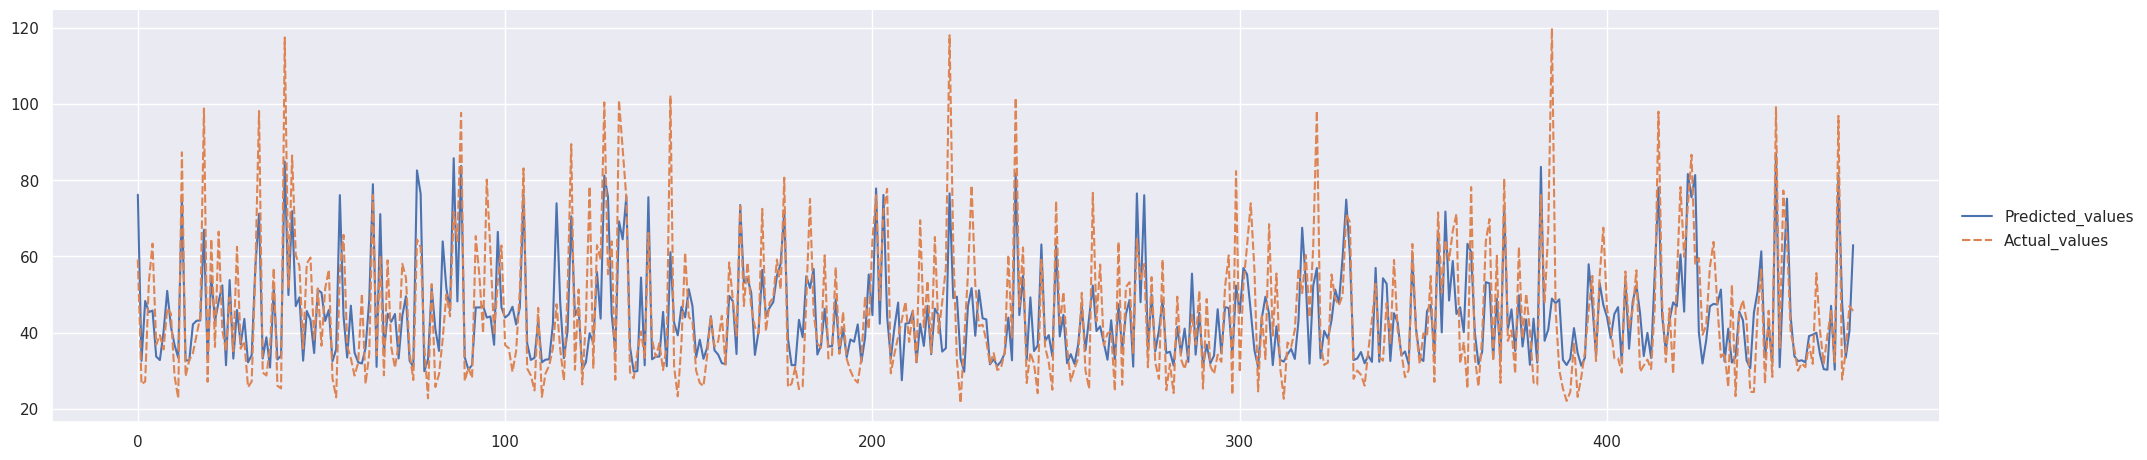

In [34]:
cbr_prediction = regr.predict(X_test)

df_pred = pd.DataFrame(cbr_prediction, columns = ["Predicted_values"])
df_pred["Actual_values"] =  y_test.values

g = sns.relplot(data = df_pred, aspect = 4, kind = 'line')
# g.set(yscale="log")#.set(xscale="log")

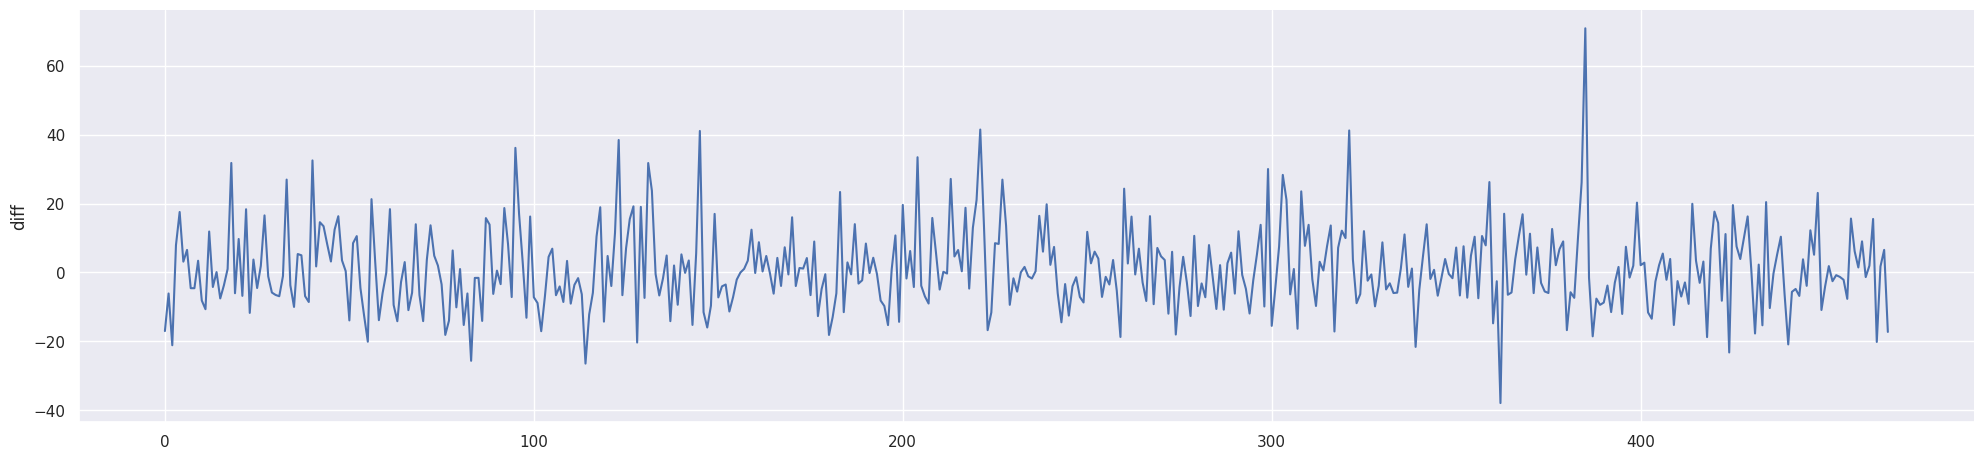

In [35]:
df_pred['diff'] = df_pred["Actual_values"] - df_pred["Predicted_values"]
sns.relplot(data = df_pred['diff'], aspect = 4, kind = 'line')
# sns.displot(data = df_pred['diff'], aspect = 2, bins=60)

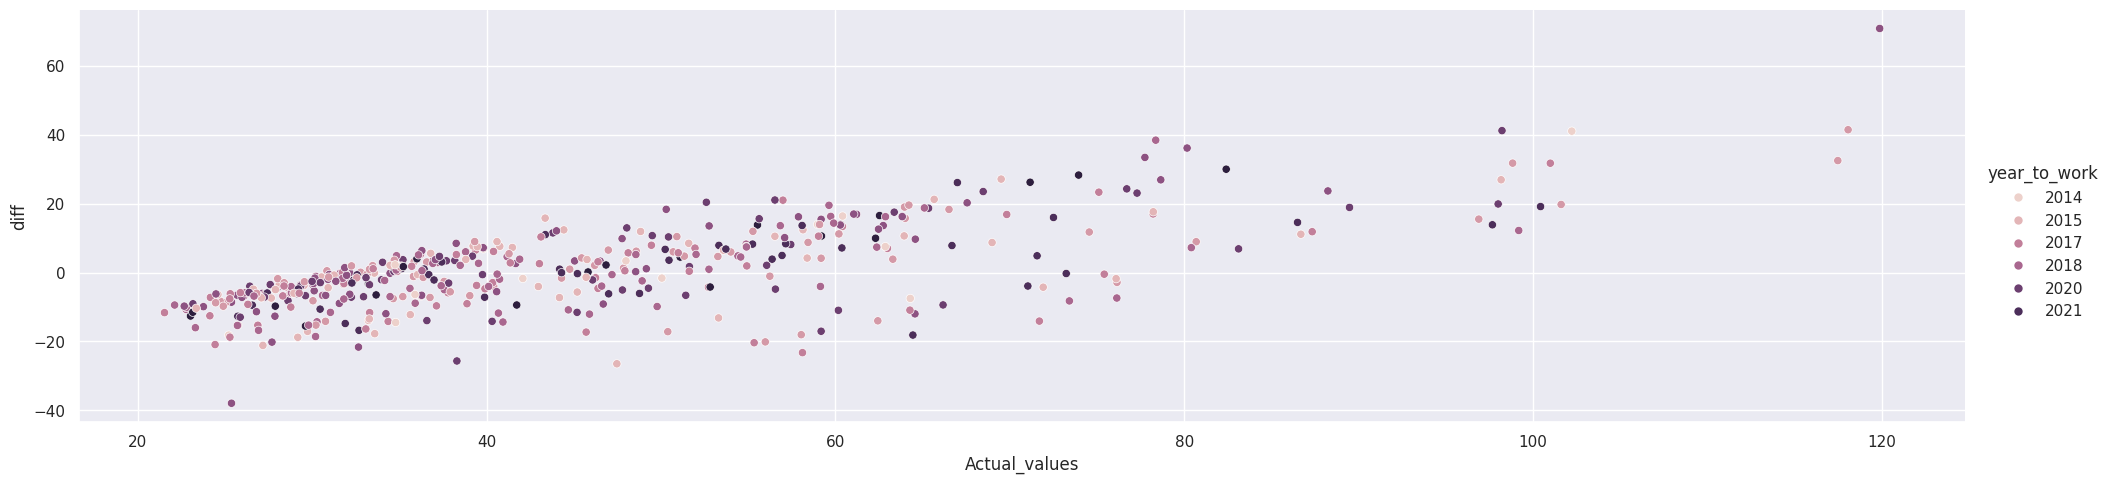

In [36]:
df_pred['year_to_work'] = X_test["year_to_work"].values

g = sns.relplot(data = df_pred,
                x = 'Actual_values',
                y = 'diff',
                hue = 'year_to_work',
                kind = 'scatter',
                aspect = 4,)

# # g.set(yscale="log")#.set(xscale="log")

In [37]:
df_pred['year_to_work'] = X_test["year_to_work"].values
# sns.displot(data = df_pred['diff'], aspect = 4, hue = 'year_to_work')

# <center> `Predicted` vs `Actual` значения

Еще два полезных графика:
* **Первый** - самый очевидный - просто отложить на двух осях фактические и предсказанные значения.
* **Второй** - изменить координаты на True-Pred и True+Pred. По сути, тот же вариант что и первый, но растянут по одной оси и сужен по второй. 

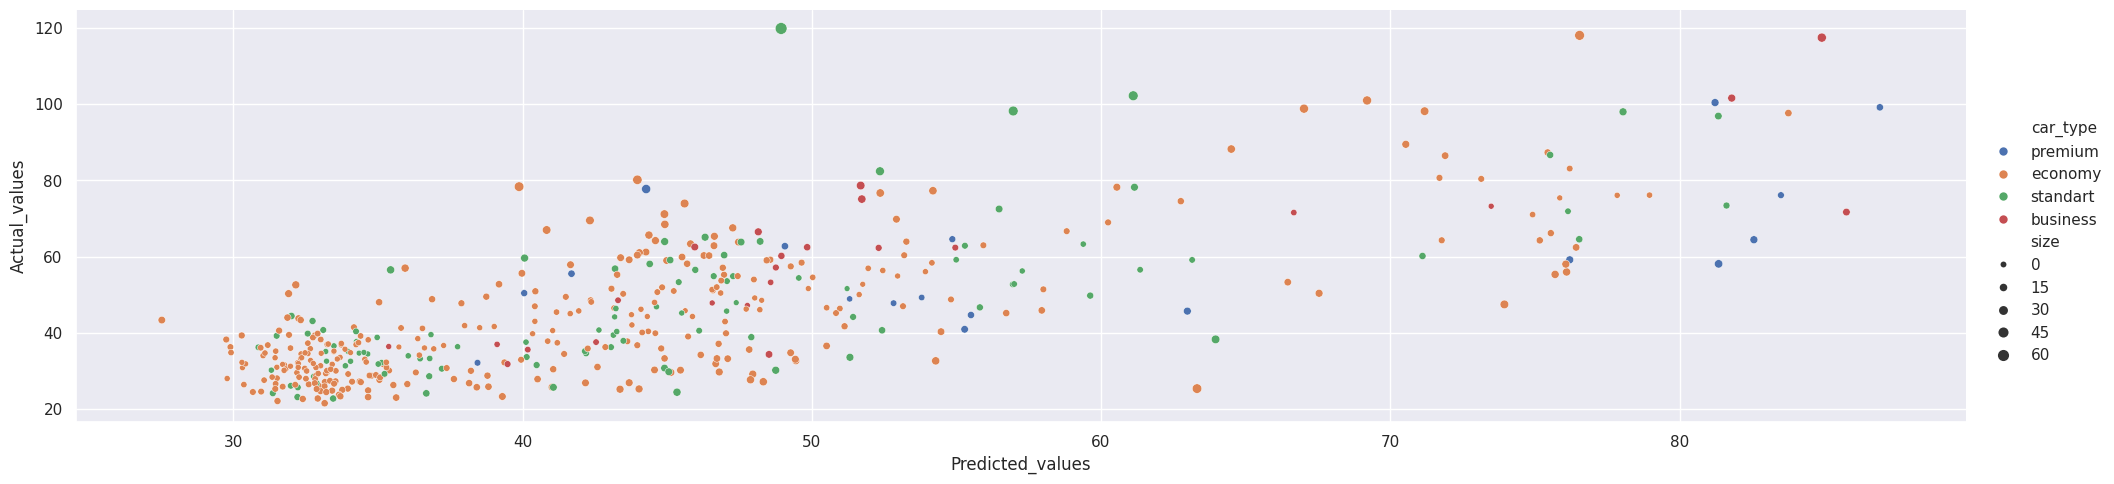

In [38]:
df_pred['car_type'] = X_test['car_type'].values
df_pred['model'] = X_test['model'].values
df_pred['size'] = abs(df_pred["diff"] // 1)

g = sns.relplot(data = df_pred,
                x = 'Predicted_values',
                y = 'Actual_values',
                hue='car_type',
                size = 'size',
                aspect = 4,
                kind = 'scatter')

# g.set(yscale="log")#.set(xscale="log")

<div class="alert alert-info">
    
* В идеале, ответы должны быть по диагонали, но тут это не так. </br>
* Видно, чтот ответы в диапазоне больших значений предсказываются хуже. Возможно, с этим что-то можно сделать!
* Можно перебрать другие категориальные фичи

# <center> График (`True - Pred`) vs (`True + Pred`)

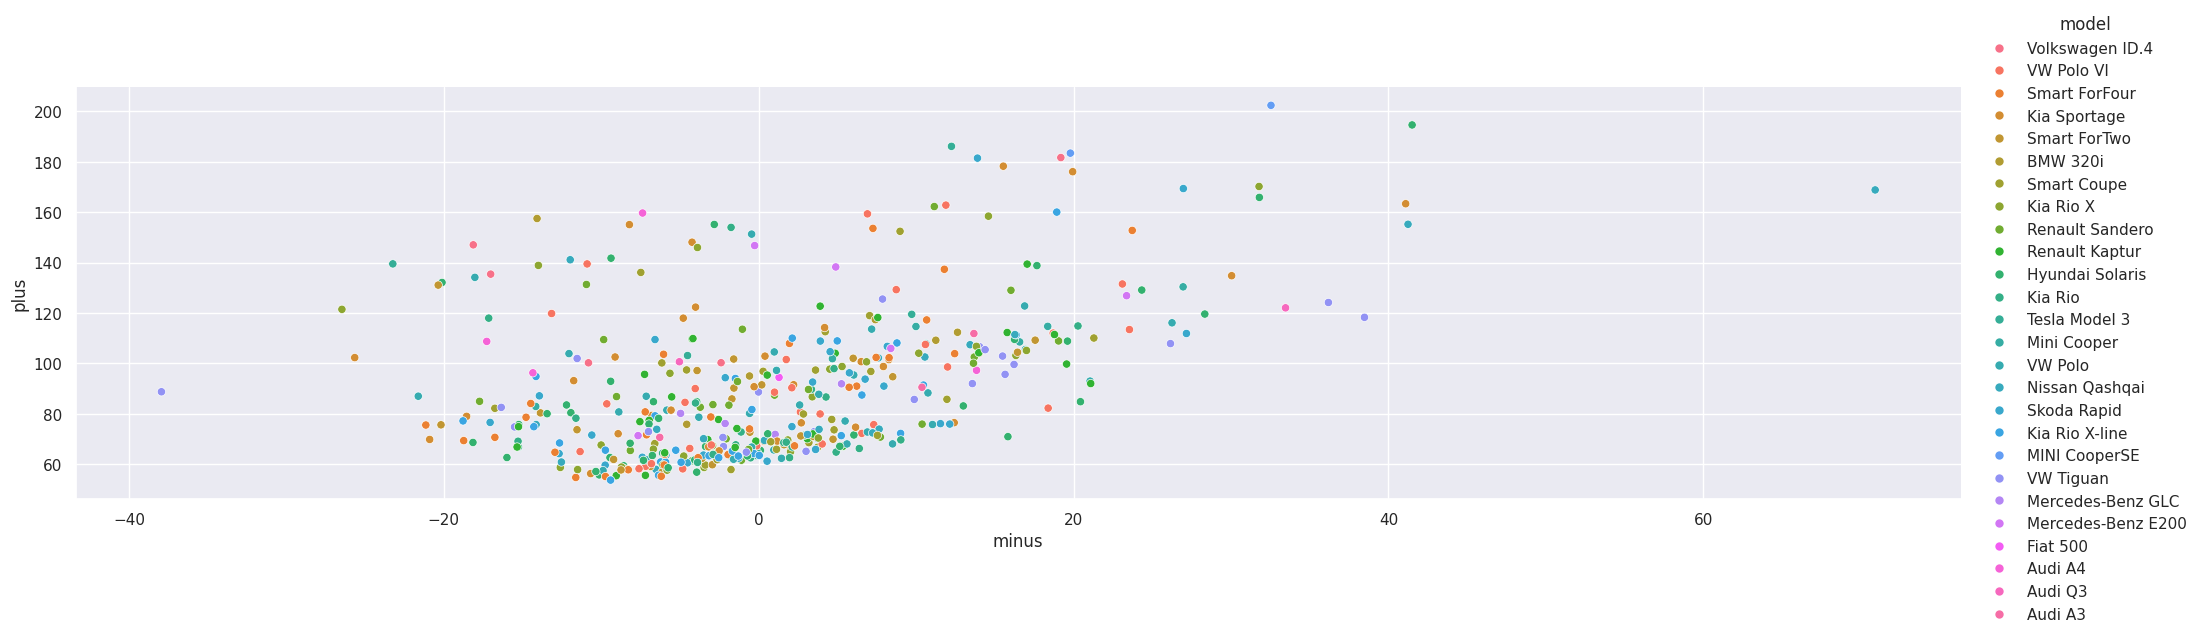

In [39]:
df_pred['plus'] = df_pred["Actual_values"] + df_pred["Predicted_values"]
df_pred['minus'] = df_pred["Actual_values"] - df_pred["Predicted_values"]

g = sns.relplot(data = df_pred,
                x = 'minus',
                y = 'plus',
                hue='model',
                aspect = 4,
                kind = 'scatter')

# g.set(yscale="log")#.set(xscale="log")

Позволяет посмотреть на график под другим углом. Говорят иногда бывает полезно. Так можно найти выбросы. 

# <center> Визуальный анализ ошибок

<center> <img src='../images/mistakes_features.JPG'>

# <center> 🧸 Выводы и заключения

<div class="alert alert-info">
    
- Метрики это хорошо, но полезно анализировать ошибки. Иначе мы стреляем вслепую
- В зависимости от типа данных всегда можно придумать свой вид интерпретации
- Анализировать легко, когда интерпретируемые данные. В иных случаях, можно опустить  
- Интерпертация => Идея => Действие


#  Доп литература
- [Очень крутая статья про визуализацию табличных данных с помощью SHAP values](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)
- [mlxnet для визуализации](https://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/)